In [2]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import correlation
import re
import gc

In [3]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py'>

In [4]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/new_output_files/"
output_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/new_result_files/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/annotation_files/"

In [5]:
# load normalized data
pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize.csv"
files = glob.glob(input_path + os.sep + '*' + os.sep + os.sep + '*' + os.sep + pattern, recursive=True)

# TODO: needs to change in the future
# TODO: process only what is not processed yet
Data = []

for file in files:
    
    filename = os.path.basename(file)
    
    try:
        
        Data_Temp = pd.read_csv(file)
        row_count = Data_Temp.shape[0]
        
        print(f"File: {filename} has {row_count} rows")
        
        Data.append(Data_Temp)
            
    except Exception as e:
        
        print(f"Error reading file {filename}: {e}")
        
        
### concat all files together
Data_aggregated = pd.concat(Data)
Data_aggregated = Data_aggregated.reset_index(drop = True)

print("Aggregated Data has shape ", Data_aggregated.shape)

File: C1231_R1_mad_robustize.csv has 384 rows
File: C1241_R1_mad_robustize.csv has 384 rows
File: C1230_R3_mad_robustize.csv has 384 rows
File: C1230_R4_mad_robustize.csv has 384 rows
File: C1231_R4_mad_robustize.csv has 384 rows
File: C1241_R2_mad_robustize.csv has 384 rows
File: C1230_R2_mad_robustize.csv has 384 rows
File: C1231_R2_mad_robustize.csv has 384 rows
File: C1241_R3_mad_robustize.csv has 384 rows
File: C1230_R1_mad_robustize.csv has 384 rows
File: C1231_R3_mad_robustize.csv has 384 rows
File: C1162_R4_mad_robustize.csv has 384 rows
File: C1175_R1_mad_robustize.csv has 384 rows
File: C1160_R2_mad_robustize.csv has 384 rows
File: C1160_R3_mad_robustize.csv has 384 rows
File: C1165_R2_mad_robustize.csv has 384 rows
File: C1176_R1_mad_robustize.csv has 384 rows
File: C1167_R1_mad_robustize.csv has 384 rows
File: C1166_R1_mad_robustize.csv has 384 rows
File: C1158_R4_mad_robustize.csv has 384 rows
File: C1158_R2_mad_robustize.csv has 384 rows
File: C1170_R1_mad_robustize.csv h

In [8]:
replicate_list = Data_aggregated['Metadata_plate_map_name'].unique()
replicate_dataframe = pd.DataFrame(replicate_list, columns=['Metadata_plate_map_name']) 

replicate_list_newcolumns = replicate_dataframe['Metadata_plate_map_name'].str.split('_', n=1, expand=True)
replicate_dataframe['Metadata_plate_name'] = replicate_list_newcolumns[0]
replicate_dataframe['Metadata_replicate_number'] = replicate_list_newcolumns[1]

replicate_counts = replicate_dataframe.groupby('Metadata_plate_name')['Metadata_replicate_number'].count().reset_index()

# Group by 'measurement_code' and filter groups that have exactly four replicates
filtered_replicate_dataframe= replicate_dataframe.groupby('Metadata_plate_name').filter(lambda x: len(x['Metadata_replicate_number']) == 4)
filtered_replicate_dataframe = filtered_replicate_dataframe.sort_values(by=['Metadata_plate_name'])

Data_aggregated_filtered = Data_aggregated[Data_aggregated['Metadata_plate_map_name'].isin(filtered_replicate_dataframe['Metadata_plate_map_name'])]

In [14]:
Data_aggregated_filtered.head()
print(Data_aggregated_filtered['Metadata_source'].unique())
print(Data_aggregated_filtered['Metadata_plate_name'].unique())

['IMTM' 'USC']
['C1231' 'C1230' 'C1162' 'C1160']


In [ ]:
# Per plate seems to be an issue
# At least with the current analysis approach
# Per source might be better for now
# But could be rethought eventually. 
# Or we can definitely break it down later onto the individual plates
# after compounding computation in per source

In [16]:
Data_aggregated_filtered_source = Data_aggregated_filtered.loc[Data_aggregated_filtered['Metadata_source'] == 'USC'].reset_index()

Data_aggregated_filtered_source_plate = Data_aggregated_filtered_source.loc[Data_aggregated_filtered_source['Metadata_plate_name'] == 'C1162'].reset_index()

# cleans up weird index columns that seem to pop up. Maybe need to investigate
Data_aggregated_filtered_source_plate = Data_aggregated_filtered_source_plate.drop(["index"], axis=1)

Data_aggregated_filtered_source_plate = Data_aggregated_filtered_source_plate.drop(["level_0"], axis=1)

In [20]:
Data_aggregated_filtered_source.head()

,Metadata_Well,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,Metadata_Well_randomized,Metadata_plate_name,Metadata_Plate,Metadata_RoughID,...,Cyto_Texture_Variance_Mito_10_02_256,Cyto_Texture_Variance_Mito_10_03_256,Cyto_Texture_Variance_Mito_3_00_256,Cyto_Texture_Variance_Mito_3_01_256,Cyto_Texture_Variance_Mito_3_02_256,Cyto_Texture_Variance_Mito_3_03_256,Cyto_Texture_Variance_Mito_5_00_256,Cyto_Texture_Variance_Mito_5_01_256,Cyto_Texture_Variance_Mito_5_02_256,Cyto_Texture_Variance_Mito_5_03_256
0,M03,Sonata,19:29:02,USC,200,HepG2_10uM,A01,C1162,C1162R4,EOS_cpd,...,9.739899,10.234126,9.756981,10.172532,9.681185,9.918125,9.515439,10.391508,10.300715,10.294461
1,C23,Sonata,19:29:02,USC,200,HepG2_10uM,A02,C1162,C1162R4,DMSO,...,0.299555,0.399010,0.290038,0.238816,0.265432,0.364529,0.263534,0.235307,0.297867,0.383976
2,O10,Sonata,19:29:02,USC,200,HepG2_10uM,A03,C1162,C1162R4,EOS_cpd,...,0.099154,0.210273,0.100786,0.184939,0.098823,0.240734,0.130820,0.217089,0.193355,0.176364
3,K04,Sonata,19:29:02,USC,200,HepG2_10uM,A04,C1162,C1162R4,EOS_cpd,...,-0.980170,-0.953509,-0.906540,-0.919822,-0.911726,-0.925222,-0.936046,-0.938890,-0.947132,-0.919098
4,H05,Sonata,19:29:02,USC,200,HepG2_10uM,A05,C1162,C1162R4,EOS_cpd,...,1.780246,1.753571,1.628963,1.641279,1.637672,1.650305,1.682392,1.736021,1.659129,1.707860


In [22]:
# get unique Metadata_RoughID
def merge_if_eos_cpd(row):

    if row['Metadata_RoughID'] == 'EOS_cpd':

        return f"{row['Metadata_Well']}_{row['Metadata_RoughID']}"
    
    else:

        return row['Metadata_RoughID']
    

Data_aggregated_filtered_source['Metadata_RoughID_unique'] = Data_aggregated_filtered_source.apply(merge_if_eos_cpd, axis=1)

# Metadata columns

Metadata_Well

Metadata_instrument

Metadata_imaging_time

Metadata_source

Metadata_imaging_timezone

Metadata_Batch

Metadata_Well_randomized

Metadata_plate_name

Metadata_Plate

Metadata_RoughID

Metadata_picklist_name

Metadata_plate_map_name

Metadata_replicate_number

Metadata_Object_Count

Metadata_user

Metadata_imaging_date

Metadata_RoughID_unique

In [23]:
columns = Data_aggregated_filtered_source.columns
for col in columns:
    print(col)

Metadata_Well
Metadata_instrument
Metadata_imaging_time
Metadata_source
Metadata_imaging_timezone
Metadata_Batch
Metadata_Well_randomized
Metadata_plate_name
Metadata_Plate
Metadata_RoughID
Metadata_picklist_name
Metadata_plate_map_name
Metadata_replicate_number
Metadata_Object_Count
Metadata_user
Metadata_imaging_date
Nuc_AreaShape_Area
Nuc_AreaShape_BoundingBoxArea
Nuc_AreaShape_BoundingBoxMaximum_X
Nuc_AreaShape_BoundingBoxMaximum_Y
Nuc_AreaShape_BoundingBoxMinimum_X
Nuc_AreaShape_BoundingBoxMinimum_Y
Nuc_AreaShape_Center_X
Nuc_AreaShape_Center_Y
Nuc_AreaShape_Compactness
Nuc_AreaShape_Eccentricity
Nuc_AreaShape_EquivalentDiameter
Nuc_AreaShape_EulerNumber
Nuc_AreaShape_Extent
Nuc_AreaShape_FormFactor
Nuc_AreaShape_MajorAxisLength
Nuc_AreaShape_MaxFeretDiameter
Nuc_AreaShape_MaximumRadius
Nuc_AreaShape_MeanRadius
Nuc_AreaShape_MedianRadius
Nuc_AreaShape_MinFeretDiameter
Nuc_AreaShape_MinorAxisLength
Nuc_AreaShape_Orientation
Nuc_AreaShape_Perimeter
Nuc_AreaShape_Solidity
Nuc_AreaSha

# Feature reduction

In [24]:
# Fature reduction
# Test show reproducibility significantly lower with full feature set!
# Thus we need some way to reduce the feature set
# But we also know that the below method produces a variable feature set
# So maybe need to rethink the method
print("Feature reduction with correlation threshold 0.9 and Outlier threshold 100")
filtered_source_feature_select = CBE.feature_reduction(Data_aggregated_filtered_source, 
                                         variance_freq_cut=0.1, 
                                         variance_unique_cut=0.1, 
                                         outlier_cutoff=100, 
                                         corr_threshold = 0.9, 
                                         print_stats = True)

Feature reduction with correlation threshold 0.9 and Outlier threshold 100
| Category           |   Original Features |   Variance Threshold |   % Variance |   Outlier Threshold |   % Outlier |   Correlation Threshold |   % Correlation |
|:-------------------|--------------------:|---------------------:|-------------:|--------------------:|------------:|------------------------:|----------------:|
| Total Features     |                2977 |                 2820 |         94.7 |                2808 |        94.3 |                     542 |            18.2 |
| Intensity          |                 180 |                  180 |        100   |                 180 |       100   |                      18 |            10   |
| Correlation        |                 180 |                  126 |         70   |                 118 |        65.6 |                      73 |            40.6 |
| AreaShape          |                 162 |                  153 |         94.4 |                 153 |      

# Consensus

In [28]:
## gets feature vector
Features_filtered_source_feature_select = CBE.get_feature_vector(filtered_source_feature_select)
Features_filtered_source_feature_select.append("Metadata_Object_Count") 

median_filtered_source_feature_select = pycytominer.consensus(
        profiles = filtered_source_feature_select , # A file or pandas DataFrame of profile data
        replicate_columns = ["Metadata_source", 
                             "Metadata_RoughID_unique",
                             "Metadata_plate_name",
                             "Metadata_Well"], # Metadata columns indicating which replicates to collapse, defaults to [“Metadata_Plate”, “Metadata_Well”]
        operation = "median", # (str) – The method used to form consensus profiles, defaults to “median”
        features = Features_filtered_source_feature_select, # (str, list) – The features to collapse, defaults to “infer”
)


# Compute toxicity

In [29]:
def pad_numbers(value):
    match = re.match(r"([A-Z])(\d+)", value)
    if match:
        letter = match.group(1)
        number = match.group(2).zfill(2)  # Pad number to 2 digits
        return f"{letter}{number}"
    return value

In [30]:
# per source and plate, plot over imaging time
# tally up also

# Missing wells need to be included
# Compounds with not all replicates also important information
# TODO: Compute missing wells
# get info for pos. and neg. controls
controls_layout_path = os.path.join(annotation_dir, "pos_neg_ctrl.csv")

try:
                
    controls_layout = pd.read_csv(controls_layout_path)
                
    # Issue in the plate layout the well numbers are not padded
    controls_layout['Metadata_Well'] = controls_layout['Metadata_Well'].apply(pad_numbers)
            
except Exception as e:
                
    print(f"Error reading {controls_layout}: {str(e)}")


controls_layout['Metadata_RoughID_unique'] = controls_layout.apply(merge_if_eos_cpd, axis=1)

# Missing compounds

In [31]:
all_ID = controls_layout['Metadata_RoughID_unique'].unique()
plate_ID = filtered_source_feature_select['Metadata_RoughID_unique'].unique()
print("HepG2: There are ",len(all_ID) - len(plate_ID),"compounds missing")

HepG2: There are  0 compounds missing


# Compounds with less than 4 replicates

In [33]:
filtered_source_feature_select_replicates = filtered_source_feature_select['Metadata_RoughID_unique'].value_counts()
print("HepG2: There are",len(filtered_source_feature_select_replicates[filtered_source_feature_select_replicates.iloc[:] < 4]), "compounds with less than 4 replicates.")

HepG2: There are 0 compounds with less than 4 replicates.


# Cell numbers

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_Object_Count', ylabel='Count'>

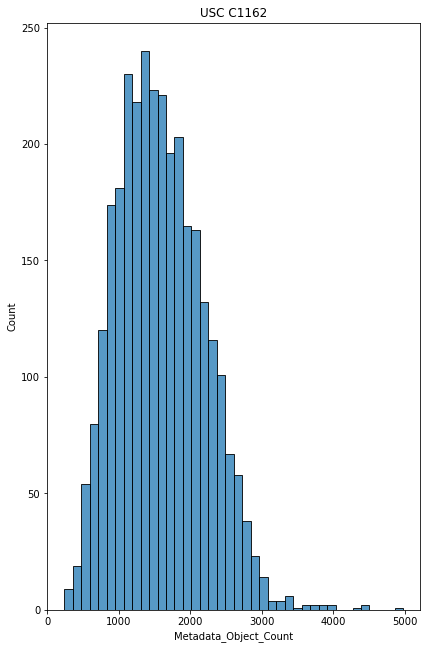

In [35]:
plt.rcParams["figure.figsize"] = (7,10)

fig, (ax1)= plt.subplots(1, sharex=True, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.histplot(data=filtered_source_feature_select, x="Metadata_Object_Count", ax = ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumber.pdf',  dpi=300)

In [39]:
# plot cell numbers of controls
filtered_source_feature_select_controls = filtered_source_feature_select[(filtered_source_feature_select["Metadata_RoughID_unique"] == "DMSO") |
                                    (filtered_source_feature_select["Metadata_RoughID_unique"] == "Nocodazole") |
                                    (filtered_source_feature_select["Metadata_RoughID_unique"] == "Tetrandrine") ]

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_RoughID_unique', ylabel='Metadata_Object_Count'>

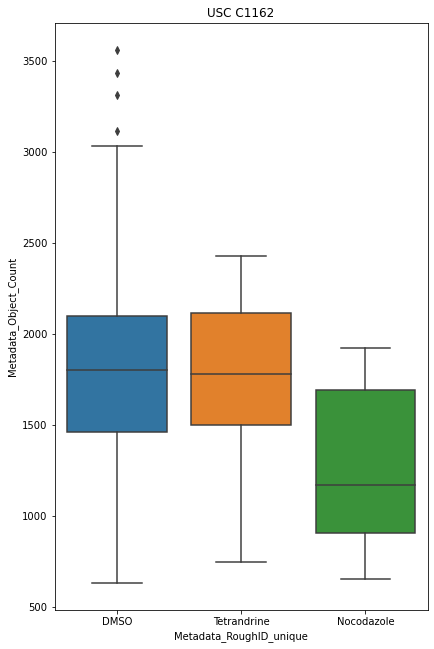

In [40]:
fig, (ax1)= plt.subplots(1, sharex=False, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.boxplot(data=filtered_source_feature_select_controls, y="Metadata_Object_Count", x="Metadata_RoughID_unique", ax=ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumberControls.pdf',  dpi=300)

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_Object_Count', ylabel='Count'>

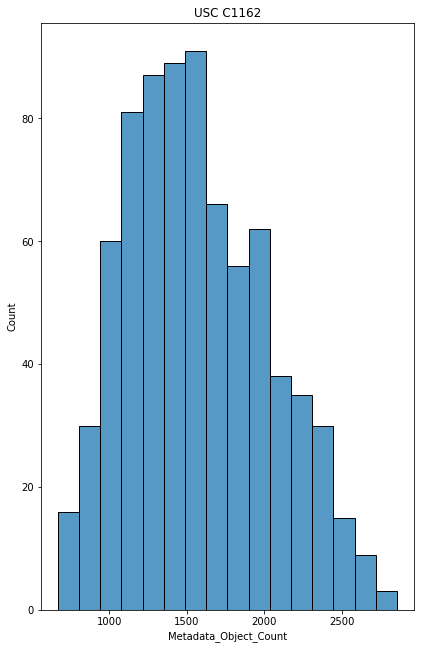

In [41]:
plt.rcParams["figure.figsize"] = (7,10)

fig, (ax1)= plt.subplots(1, sharex=True, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.histplot(data=median_filtered_source_feature_select, x="Metadata_Object_Count", ax = ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumber.pdf',  dpi=300)

<AxesSubplot: title={'center': 'USC C1162'}, xlabel='Metadata_RoughID_unique', ylabel='Metadata_Object_Count'>

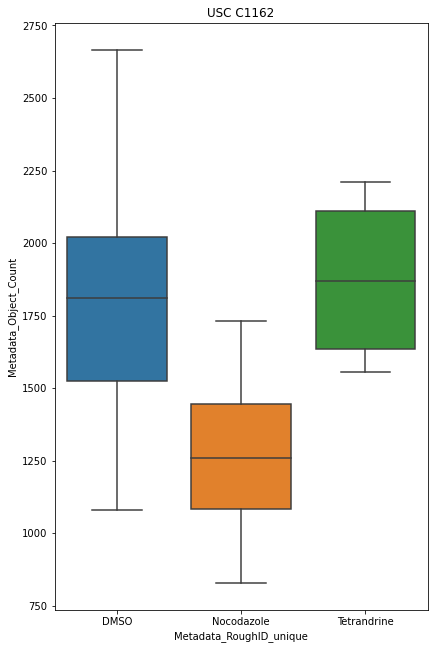

In [42]:
# plot cell numbers of controls
median_filtered_source_feature_select_controls = median_filtered_source_feature_select[(median_filtered_source_feature_select["Metadata_RoughID_unique"] == "DMSO") |
                                                                                                   (median_filtered_source_feature_select["Metadata_RoughID_unique"] == "Tetrandrine") |
                                                                                                   (median_filtered_source_feature_select["Metadata_RoughID_unique"] == "Nocodazole") ]


fig, (ax1)= plt.subplots(1, sharex=False, sharey=True)
ax1.title.set_text('USC C1162')
fig.tight_layout(pad=5.0)
sns.boxplot(data=median_filtered_source_feature_select_controls, y="Metadata_Object_Count", x="Metadata_RoughID_unique", ax=ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumberControls.pdf',  dpi=300)

# Toxicity

In [43]:
missing_compounds = pd.merge(controls_layout, 
                                 filtered_source_feature_select,
                                 on = ["Metadata_RoughID_unique"],
                                 how = "left",
                                 indicator = True)

missing_compounds = missing_compounds[missing_compounds["_merge"] == 'left_only'].dropna(axis='columns')

In [44]:
missing_compounds.head()

,Metadata_Well_x,Metadata_RoughID_x,Metadata_RoughID_unique,Metadata_Well_y,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,Metadata_Well_randomized,...,Cyto_Texture_InfoMeas1_DNA_5_03_256,Cyto_Texture_InfoMeas1_ER_10_03_256,Cyto_Texture_InfoMeas1_ER_5_00_256,Cyto_Texture_InfoMeas1_ER_5_03_256,Cyto_Texture_InfoMeas1_Mito_3_00_256,Cyto_Texture_InfoMeas1_Mito_3_01_256,Cyto_Texture_InfoMeas2_ER_10_03_256,Cyto_Texture_InverseDifferenceMoment_AGP_3_02_256,Cyto_Texture_SumAverage_ER_3_02_256,_merge


In [48]:
## 2.5 Std from population median
# TODO: problematic tox threshold does not work currently
# Now set to 1.5 STDs from sample median
# Works well on larger samples...???
SD_Threshold = 1.5

tox_threshold_1 = median_filtered_source_feature_select["Metadata_Object_Count"].median() - (SD_Threshold * filtered_source_feature_select["Metadata_Object_Count"].std())
print("Tox threshold:", tox_threshold_1)

FMP_Toxic_conditions_1 = filtered_source_feature_select.loc[filtered_source_feature_select["Metadata_Object_Count"] < tox_threshold_1]
print("Toxic conditions: " + str(len(FMP_Toxic_conditions_1 )) + " compounds (" + str(SD_Threshold) + " Std from population median)")

Tox threshold: 618.3991797800704
Toxic conditions: 91 compounds (1.5 Std from population median)


# Raw % replication


In [63]:
replicating_source, corr_replicating_source = CBE.remove_non_reproducible(
    filtered_source_feature_select, 
    n_samples = 5000, 
    n_replicates = 4, 
    ID_col = "Metadata_RoughID_unique", 
    description = "USC")


| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| USC           |                  15.5 |
Nonreplicating conditions removed with threshold 0.26
Old shape (3072, 559)
New shape (688, 559)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


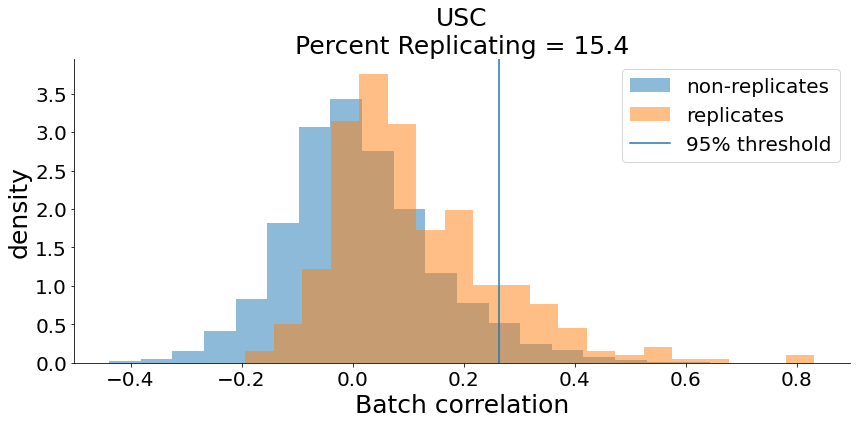

In [52]:

n_experiments = len(corr_replicating_source)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_source.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_source.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_source.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_source.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_source.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()

plt.tight_layout()

# plt.savefig(figure_path + str(date.today()) + "_HepG2_Percent_Replicating.pdf", 
#            transparent=False, 
#            bbox_inches='tight', 
#            dpi = 600)

# Compute induction 

In [ ]:
# based on consensus profiles
# In the original analysis this is done after removing toxic compounds
# per source and plate, plot over imaging time
# tally up also

# "Metadata_source", 
# "Metadata_RoughID_unique",
# "Metadata_plate_name",
# "Metadata_Well"

In [53]:
## gets feature vector
Features_median_filtered_source_feature_select = CBE.get_feature_vector(median_filtered_source_feature_select)


len(median_filtered_source_feature_select["Metadata_RoughID_unique"].unique())

355

In [54]:
def remove_non_active(df: pd.DataFrame, 
                      key_col, 
                      feature_activity_threshold=3.0, 
                      induction_threshold=5):
    """
    removes compounds via induction threshold
    :param df: consensus, feature selected CellProfiler Profiles
    :param key_col = ["Metadata_EOS", "Metadata_Plate", "Metadata_Concentration"]
    :param feature_activity_threshold: z-score where feature is considered active
    :param induction_threshold: % of active features where compound passes threshold
    :return: new DataFrame with active compounds, new DataFrame with non active compounds
    """
    # removes key columns
    feature_df = df.drop(columns=key_col)
 
    # percent of features equal or higher than activity threshold
    induction = (feature_df >= feature_activity_threshold).sum(axis=1) / len(feature_df.columns) * 100

    # treatments with induction equal or higher than induction threshold
    Data_active = df[(induction >= induction_threshold)]
    
    # treatments with induction lower than induction threshold
    Data_non_active = df[(induction < induction_threshold)]
    
    return Data_active, Data_non_active

In [55]:
key_col = ["Metadata_source", "Metadata_RoughID_unique", "Metadata_plate_name", "Metadata_Well"]

active, non_active = remove_non_active(median_filtered_source_feature_select, 
                                                   key_col,
                                                   3.0, 
                                                   5.0)

print("Active:", len(active["Metadata_RoughID_unique"].unique()))
print("Non-active:", len(non_active["Metadata_RoughID_unique"].unique()))

Active: 44
Non-active: 353


In [ ]:
non_active_EOS = pd.DataFrame(non_active["Metadata_RoughID_unique"].unique(), columns = ["Metadata_RoughID_unique"])

In [56]:
Reduced_active = filtered_source_feature_select[
    (filtered_source_feature_select['Metadata_RoughID_unique'].isin(active['Metadata_RoughID_unique']))]

# Compute metrics over replicates

In [57]:
# % replication over plates per source, per plate, plot over imaging time

In [61]:
active_replicating, active_corr_replicating_df = CBE.remove_non_reproducible(
    Reduced_active, 
    n_samples = 5000, 
    n_replicates = 4, 
    ID_col = "Metadata_Well", 
    description = "Data_50")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| Data_50       |                   8.9 |
Nonreplicating conditions removed with threshold 0.57
Old shape (360, 559)
New shape (32, 559)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


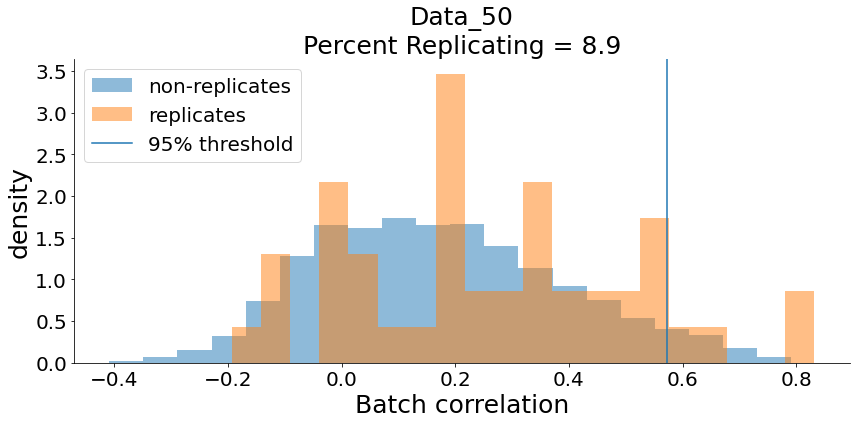

In [62]:
# plot % replicating
corr_replicating_df = active_corr_replicating_df

n_experiments = len(corr_replicating_df)


plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()

# plt.savefig(figure_path + str(date.today()) + "_HepG2_Percent_Replicating_Induction_Filter.pdf", 
            #transparent=False, 
            #bbox_inches='tight', 
            #dpi = 600)# 

In [ ]:
# Threshold computation does not work with smaller sample size
# Compare with bioactives data. Suspect this is the case there too.

In [ ]:
# TODO: If all replicates exist:
# TODO: Feature reduction per plate
# TODO: Compute number of toxic compounds
# TODO: Compute raw % replication
# TODO: Compute compound activity based on DMSO
# TODO: Compute % replication after compound filters

In [ ]:
# TODO: Over entire dataset that has all replicates available